In [177]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
data = pd.read_csv("greatlakedata/superior1918.csv", header = 2, index_col = 0) #read data
data = data.drop([2021, 2022]) #drop years with nan values
a = data.unstack().values #unstack 2d data into one long 1d list
a

array([183.25, 183.38, 183.29, ..., 183.67, 183.74, 183.63])

In [178]:
data_average = np.mean(a) #standardization
data_deviation = np.std(a)
for i in range(len(a)):
    a[i] -= data_average
    a[i] /= data_deviation
a

array([-0.79553777, -0.15872708, -0.59959602, ...,  1.26185059,
        1.60474865,  1.06590884])

In [179]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(a, model='additive', period = 100) 
result.trend[np.logical_not(np.isnan(result.trend))]

array([-0.41786005, -0.40218471, -0.38601951, ..., -0.03748813,
       -0.02328235, -0.00809686])

In [180]:
a = result.trend[np.logical_not(np.isnan(result.trend))]
x = []
y = []
for i in range(len(a)-24):
    x.append(a[i:i+24])
    y.append(a[i+24])
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, shuffle = True, random_state = 39)
x_train

[array([0.43448656, 0.43693583, 0.433017  , 0.42958802, 0.43865032,
        0.45995899, 0.47367491, 0.47857345, 0.48396185, 0.48665605,
        0.4861662 , 0.48445171, 0.49473865, 0.50918935, 0.51261833,
        0.50967921, 0.51286326, 0.52266035, 0.52437484, 0.51408789,
        0.49743285, 0.483472  , 0.47734882, 0.48004302]),
 array([0.43595612, 0.44452857, 0.44599814, 0.44624306, 0.44648799,
        0.44060974, 0.43277207, 0.43203729, 0.43522134, 0.43767061,
        0.43448656, 0.42909816, 0.42395469, 0.42150542, 0.41268804,
        0.40166632, 0.39529821, 0.39235908, 0.38795039, 0.3798678 ,
        0.37398954, 0.37031564, 0.37496925, 0.38231707]),
 array([0.5258444 , 0.52364005, 0.53711105, 0.55572552, 0.56478782,
        0.56601246, 0.56258348, 0.55425595, 0.54470379, 0.54323423,
        0.54078496, 0.53417192, 0.53637627, 0.54690814, 0.5618487 ,
        0.56748202, 0.56380811, 0.56111391, 0.55548059, 0.5537661 ,
        0.55744001, 0.56993129, 0.58119794, 0.57433998]),
 array([0.

In [181]:
from torch.utils.data import DataLoader,Dataset
class Pd(Dataset):
    def __init__(self, x, y):
        self.input = x
        self.target = y
    def __getitem__(self, index):
        inputs = self.input[index]
        target = self.target[index]
        return inputs, target
    def __len__(self):
        return len(self.input)
    
train_dataset = Pd(x_train, y_train)
train_dataLoader = DataLoader(train_dataset, batch_size = 32, shuffle = True)

test_dataset = Pd(x_test, y_test)
test_dataLoader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

In [182]:
import torch as tr
import torch.nn as nn
class RNN(nn.Module):
    def __init__(self, input_size):
        super(RNN, self).__init__()
        self.rnn = nn.LSTM(
            input_size = input_size,
            hidden_size = 128, #number of features coming out of the LSTM layer
            num_layers = 1, #number of LSTM layers
            #batch_first = True,
        )
        self.out = nn.Sequential(
            nn.Dropout(0.5),
            
            nn.Linear(128, 32),
            nn.BatchNorm1d(1),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(32, 1),
        )
        
    def forward(self, x):
        r_out, (h_n, h_c) = self.rnn(x, None) #initial h and c is 0
        out = self.out(r_out)
        return out

model = RNN(24)
model_run = RNN(24)
loss_function = nn.MSELoss()
op = tr.optim.Adam(model.parameters(), lr=0.0001)
op_2 = tr.optim.Adam(model.parameters(), lr = 0.00001)
model_2 = tr.load("Superior/sens_superior.pt")

In [17]:
device = tr.device("cuda" if tr.cuda.is_available() else "cpu")
model = model.to(device)
all_loss_train = []
all_loss_test = []
epochs = 168
last_pred = []
last_y = []
for i in range(epochs):
    model.train()
    #if i > 50:
        #op = op_2
    for index_train, data in enumerate(train_dataLoader):
        x = tr.as_tensor(tr.unsqueeze(data[0], dim = 1), dtype = tr.float32).to(device)
        y = tr.as_tensor(tr.unsqueeze(data[1], dim = 1), dtype = tr.float32).to(device)
        op.zero_grad()
        pred = model(x)
        loss_train = loss_function(tr.squeeze(pred), tr.squeeze(y))
        loss_train.backward()
        op.step()
    model.eval()
    for index_test, data in enumerate(test_dataLoader):
        x = tr.as_tensor(tr.unsqueeze(data[0], dim = 1), dtype = tr.float32).to(device)
        y = tr.as_tensor(tr.unsqueeze(data[1], dim = 1), dtype = tr.float32).to(device)
        op.zero_grad()
        pred = model(x)
        #if i%20 == 0:
            #print(tr.squeeze(pred))
        if i == epochs - 1:
            last_y.append(tr.squeeze(y).tolist())
            last_pred.append(tr.squeeze(pred).tolist())
        loss_test = loss_function(tr.squeeze(pred), tr.squeeze(y))
        op.step()
    print ("Epoch %d, Loss Train: %f, Loss Test: %f"%(i, loss_train, loss_test))
    all_loss_train.append(loss_train)
    all_loss_test.append(loss_test)

Epoch 0, Loss Train: 0.046965, Loss Test: 0.017535
Epoch 1, Loss Train: 0.044519, Loss Test: 0.018978
Epoch 2, Loss Train: 0.007312, Loss Test: 0.017587
Epoch 3, Loss Train: 0.022033, Loss Test: 0.017262
Epoch 4, Loss Train: 0.091994, Loss Test: 0.019374
Epoch 5, Loss Train: 0.013102, Loss Test: 0.017684
Epoch 6, Loss Train: 0.015790, Loss Test: 0.018419
Epoch 7, Loss Train: 0.053274, Loss Test: 0.017551
Epoch 8, Loss Train: 0.041354, Loss Test: 0.018141
Epoch 9, Loss Train: 0.020096, Loss Test: 0.017159
Epoch 10, Loss Train: 0.039721, Loss Test: 0.017533
Epoch 11, Loss Train: 0.087044, Loss Test: 0.017784
Epoch 12, Loss Train: 0.017023, Loss Test: 0.017401
Epoch 13, Loss Train: 0.076232, Loss Test: 0.017013
Epoch 14, Loss Train: 0.052935, Loss Test: 0.018194
Epoch 15, Loss Train: 0.025436, Loss Test: 0.017125
Epoch 16, Loss Train: 0.078375, Loss Test: 0.018263
Epoch 17, Loss Train: 0.059110, Loss Test: 0.016177
Epoch 18, Loss Train: 0.012355, Loss Test: 0.016086
Epoch 19, Loss Train: 

KeyboardInterrupt: 

In [50]:
device = tr.device("cuda" if tr.cuda.is_available() else "cpu")
model = model.to(device)
all_loss_train = []
all_loss_test = []
lowest = 100
timer = 20
i = 0
run = True
last_pred = []
last_y = []
while run == True:
    model.train()
    #if i > 50:
        #op = op_2
    for index_train, data in enumerate(train_dataLoader):
        x = tr.as_tensor(tr.unsqueeze(data[0], dim = 1), dtype = tr.float32).to(device)
        y = tr.as_tensor(tr.unsqueeze(data[1], dim = 1), dtype = tr.float32).to(device)
        op.zero_grad()
        pred = model(x)
        loss_train = loss_function(tr.squeeze(pred), tr.squeeze(y))
        loss_train.backward()
        op.step()
    model.eval()
    temp_y = []
    temp_pred = []
    for index_test, data in enumerate(test_dataLoader):
        x = tr.as_tensor(tr.unsqueeze(data[0], dim = 1), dtype = tr.float32).to(device)
        y = tr.as_tensor(tr.unsqueeze(data[1], dim = 1), dtype = tr.float32).to(device)
        op.zero_grad()
        pred = model(x)
        #if i%20 == 0:
            #print(tr.squeeze(pred))
        temp_y.append(tr.squeeze(y).tolist())
        temp_pred.append(tr.squeeze(pred).tolist())
        loss_test = loss_function(tr.squeeze(pred), tr.squeeze(y))
        op.step()
    print ("Epoch %d, Loss Train: %f, Loss Test: %f"%(i, loss_train, loss_test))
    all_loss_train.append(loss_train.detach())
    all_loss_test.append(loss_test.detach())
    if loss_test < lowest:
        timer = 20
        lowest = loss_test
        last_y = temp_y
        last_pred = temp_pred
        model_run = model
    else:
        timer -= 1
    if timer == 0:
        run = False
    i += 1

Epoch 0, Loss Train: 0.155158, Loss Test: 0.148531
Epoch 1, Loss Train: 0.258062, Loss Test: 0.040815
Epoch 2, Loss Train: 0.243260, Loss Test: 0.020031
Epoch 3, Loss Train: 0.088983, Loss Test: 0.016852
Epoch 4, Loss Train: 0.069600, Loss Test: 0.016705
Epoch 5, Loss Train: 0.130525, Loss Test: 0.012902
Epoch 6, Loss Train: 0.073131, Loss Test: 0.012224
Epoch 7, Loss Train: 0.085676, Loss Test: 0.011365
Epoch 8, Loss Train: 0.199574, Loss Test: 0.010859


KeyboardInterrupt: 

In [185]:
device = tr.device("cuda" if tr.cuda.is_available() else "cpu")
model = tr.load("Superior/superior_lstm.pt")
model = model.to(device)
model.eval()
temp_y = []
temp_pred = []
for index_test, data in enumerate(test_dataLoader):
    x = tr.as_tensor(tr.unsqueeze(data[0], dim = 1), dtype = tr.float32).to(device)
    y = tr.as_tensor(tr.unsqueeze(data[1], dim = 1), dtype = tr.float32).to(device)
    op.zero_grad()
    pred = model(x)
    #if i%20 == 0:
        #print(tr.squeeze(pred))
    temp_y.append(tr.squeeze(y).tolist())
    temp_pred.append(tr.squeeze(pred).tolist())
    loss_test = loss_function(tr.squeeze(pred), tr.squeeze(y))
    op.step()
print(loss_test.detach())


tensor(0.0031)


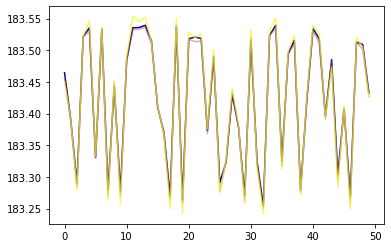

In [186]:
def unstack(data, dev, avg):
    y = []
    for i in range(len(data)):
        for j in range(len(data[i])):
            y.append((data[i][j] * dev + avg))
    return y
y = []
lstm = []
meta = []
y = unstack(temp_y, data_deviation, data_average)
lstm = unstack(temp_pred, data_deviation, data_average)
meta = unstack(np.load("Superior/superior_meta_pred.npy", allow_pickle = True), data_deviation, data_average)
import cycler
N = 3
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.plasma(np.linspace(0,1,N)))
plt.plot(lstm[0:50])
plt.plot(meta[0:50], alpha = 0.5)
plt.plot(y[0:50], alpha = 0.7)

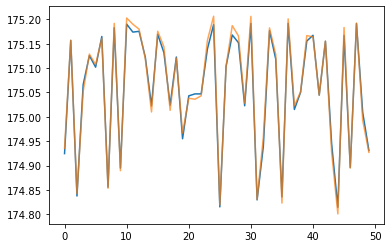

In [76]:
plt.plot(meta[0:50])
plt.plot(y[0:50], alpha = 0.7)

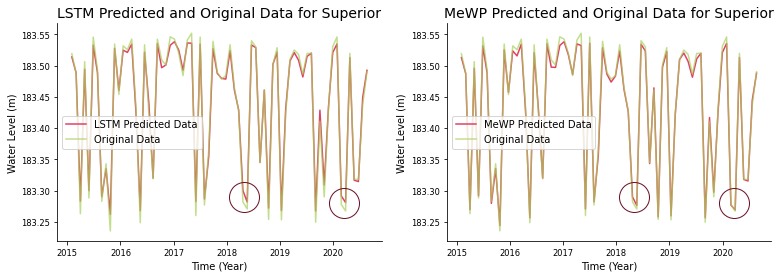

In [205]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
fig, ax = plt.subplots(1, 2, figsize = (12.8, 4))
def plot(ym, ym1, index, x, title, label_1):
    global ax
    ax[index].set_title(title, fontsize = 14)
    ax[index].plot(x, ym, label = label_1, color = "#E04065")
    ax[index].plot(x, ym1, label = "Original Data", color = "#A9D05C", alpha = 0.7)
    ax[index].set_ylabel('Water Level (m)', fontsize = 'medium')
    ax[index].set_xlabel('Time (Year)', fontsize = 'medium')
    ax[index].tick_params(axis='both', labelsize='small')
    ax[index].spines['right'].set_visible(False)
    ax[index].spines['top'].set_visible(False)
    ax[index].legend()
    bottom, top = plt.ylim()
    ax[index].plot_date(datetime.datetime(2018, 5, 1, 1, 1), 183.29,
                'og', # marker style 'o', color 'g'
                color = "#6B0F25",
                fillstyle='none', # circle is not filled (with color)
                ms=30.0)
    ax[index].plot_date(datetime.datetime(2020, 3, 17, 1, 1), 183.28,
                'og', # marker style 'o', color 'g'
                color = "#6B0F25",
                fillstyle='none', # circle is not filled (with color)
                ms= 30.0)
    #circle1 = plt.Circle((datetime.datetime(2018, 2, 1, 1, 1), 175.2), 5.0 / len(x), color='#6B0F25', fill = False)
    #ax[index].add_artist(circle1)
    
    
import datetime
x = [datetime.datetime(2015, 2, 1, 1, 1) + datetime.timedelta(weeks = 4.2*i) for i in range(70)]
plot(lstm[-70:], y[-70:], 0, x, "LSTM Predicted and Original Data for Superior", "LSTM Predicted Data")
plot(meta[-70:], y[-70:], 1, x, "MeWP Predicted and Original Data for Superior", "MeWP Predicted Data")
fig.savefig("superior_lstm_meta.pdf")

In [88]:
tr.save(model_run, 'superior_lstm.pt')
np_last_y = np.array(last_y, dtype = object)
np_last_pred = np.array(last_pred, dtype = object)
np_loss_train = np.array(all_loss_train)
np_loss_test = np.array(all_loss_test)
np.save('superior_lstm_y', np_last_y)
np.save('superior_lstm_pred', np_last_pred)
np.save('superior_lstm_train', np_loss_train)
np.save('superior_lstm_test', np_loss_test)

In [36]:
for i in range(len(all_loss_test)):
    all_loss_test[i] = all_loss_test[i].detach()

In [35]:
all_loss_train

[tensor(0.2297),
 tensor(0.1170),
 tensor(0.1725),
 tensor(0.0563),
 tensor(0.0560),
 tensor(0.1310),
 tensor(0.0410),
 tensor(0.1458),
 tensor(0.0536),
 tensor(0.0603),
 tensor(0.1327),
 tensor(0.1255),
 tensor(0.0321),
 tensor(0.0253),
 tensor(0.0530),
 tensor(0.0487),
 tensor(0.0276),
 tensor(0.0363),
 tensor(0.0521),
 tensor(0.0612),
 tensor(0.0277),
 tensor(0.0194),
 tensor(0.0493),
 tensor(0.0545),
 tensor(0.0189),
 tensor(0.0604),
 tensor(0.0554),
 tensor(0.0393),
 tensor(0.0572),
 tensor(0.0490),
 tensor(0.0305),
 tensor(0.0530),
 tensor(0.0391),
 tensor(0.0279),
 tensor(0.0121),
 tensor(0.0253),
 tensor(0.0133),
 tensor(0.0341),
 tensor(0.0472),
 tensor(0.0165),
 tensor(0.0319),
 tensor(0.0368),
 tensor(0.0447),
 tensor(0.0643),
 tensor(0.0406),
 tensor(0.0194),
 tensor(0.0576),
 tensor(0.0643),
 tensor(0.0107),
 tensor(0.0118),
 tensor(0.1269),
 tensor(0.0506),
 tensor(0.0182),
 tensor(0.0548),
 tensor(0.0360),
 tensor(0.0191),
 tensor(0.0308),
 tensor(0.0157),
 tensor(0.0289